<img src="PyDataLT1.png">

<img src="PyDataLT2.png">

<img src="PyDataLT3.png">

In [3]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline


# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

file_name = "kwh.csv"
data_frame = pd.read_csv(file_name, index_col='月次', parse_dates=True, dtype=float)
data_frame.head()

#=====================================================================================

import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore') # 警告非表示（収束：ConvergenceWarning）

# 総当たりで、AICが最小となるSARIMAの次数を探す
max_p = 3
max_q = 3
max_d = 1
max_sp = 1
max_sq = 1
max_sd = 1
pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)
modelSelection = pd.DataFrame(index=range(pattern), columns=["model", "aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            data_frame, 
                            order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()
                        # SARIMA (p, d, q) * (sp, sd ,sq)
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + ","+ str(d) + ","+ str(q) + "), season=("+ str(sp) + ","+ str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic  # AIC:赤池情報量基準
                        num = num + 1

In [4]:
# モデルごとの結果確認
print(modelSelection.head())
print(modelSelection.tail())
# AIC最小モデル
print(modelSelection[modelSelection.aic == min(modelSelection.aic)])  # AICは、小さいほど良い。　ただし、比較ができるのは同じ統計モデル

                           model      aic
0  order=(1,0,0), season=(0,0,0)  2794.94
1  order=(1,0,0), season=(0,0,1)  2490.75
2  order=(1,0,0), season=(0,1,0)  2303.67
3  order=(1,0,0), season=(0,1,1)  2063.86
4  order=(1,0,0), season=(1,0,0)  2305.08
                             model      aic
187  order=(3,1,3), season=(0,1,1)   1990.5
188  order=(3,1,3), season=(1,0,0)  2268.05
189  order=(3,1,3), season=(1,0,1)  2262.43
190  order=(3,1,3), season=(1,1,0)  2025.16
191  order=(3,1,3), season=(1,1,1)  1992.32
                             model     aic
187  order=(3,1,3), season=(0,1,1)  1990.5


In [5]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore') # 警告非表示（収束：ConvergenceWarning）

p=3
d=1
q=3
sp=0
sd=1
sq=1

sarima = sm.tsa.SARIMAX(
    data_frame, 
    order=(p,d,q), 
    seasonal_order=(sp,sd,sq,12), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()

2007-04-01        0.000000
2007-05-01    46475.396542
2007-06-01    34471.034962
2007-07-01    23912.596740
2007-08-01    29896.134117
Freq: MS, dtype: float64


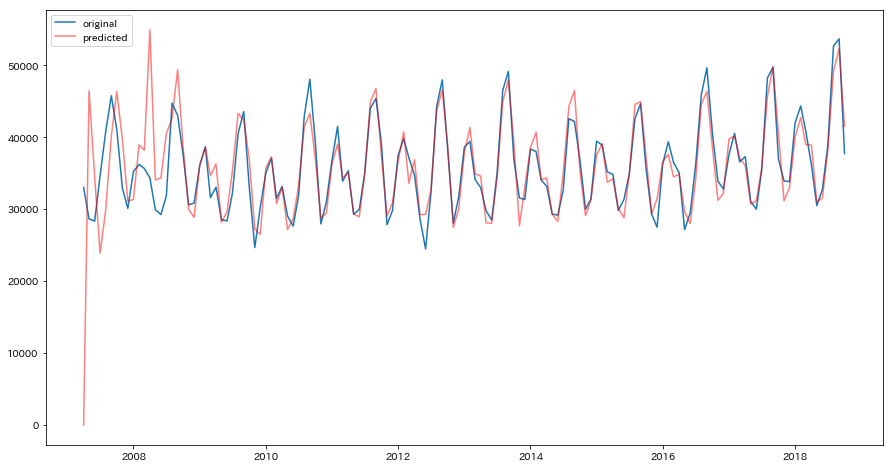

In [6]:
# 予測
df_pred = sarima.predict('2007-04-01', '2018-10-01')

plt.figure(figsize=(15,8))
# 実データと予測結果の図示
plt.plot(data_frame, label='original')
plt.plot(df_pred, label='predicted', color='red', alpha=0.5)
plt.legend(loc='best')

print(df_pred.head())

2018-10-01    41532.025821
2018-11-01    33305.221926
2018-12-01    34426.618029
2019-01-01    42659.640705
2019-02-01    44946.909823
Freq: MS, dtype: float64
            lower 電力量[kWh]  upper 電力量[kWh]
2018-10-01    37272.212170    45791.839472
2018-11-01    29045.412116    37565.031737
2018-12-01    29700.054875    39153.181183
2019-01-01    37831.896517    47487.384893
2019-02-01    40091.600797    49802.218850


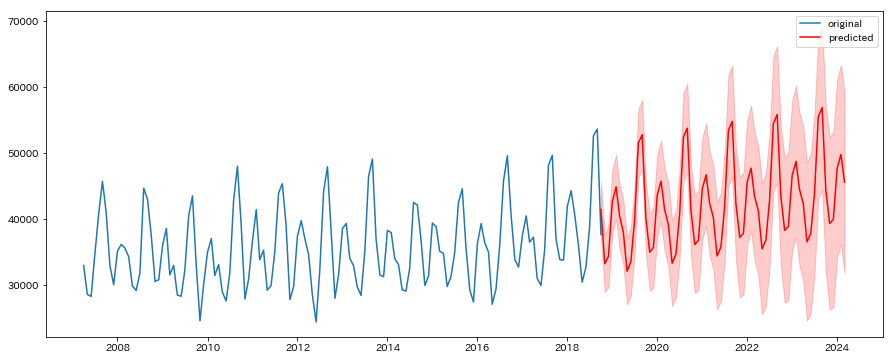

In [7]:
# 予測
df_pred = sarima.predict('2018-10-01', '2024-03-01')
df_pred_by = sarima.get_prediction('2018-10-01', '2024-03-01')
df_pred_ci = df_pred_by.conf_int(alpha=0.05)

plt.figure(figsize=(15,6))
# 実データと予測結果の図示
plt.plot(data_frame, label='original')
plt.plot(df_pred, label='predicted', color='red')
plt.fill_between(df_pred_ci.index, df_pred_ci.iloc[:, 0], df_pred_ci.iloc[:, 1], color='r', alpha=0.2)
plt.legend(loc='best')
plt.savefig('kwh_pred.png')

print(df_pred.head())
print(df_pred_ci.head())
df_pred.to_csv('kwh_pred.csv')

<img src="PyDataLT9.png">

                                 Statespace Model Results                                 
Dep. Variable:                           電力量[kWh]   No. Observations:                  139
Model:             SARIMAX(3, 1, 3)x(0, 1, 1, 12)   Log Likelihood                -987.249
Date:                            Fri, 07 Dec 2018   AIC                           1990.498
Time:                                    01:49:39   BIC                           2012.102
Sample:                                04-01-2007   HQIC                          1999.261
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2209      0.207      5.909      0.000       0.816       1.626
ar.L2         -1.1653      0.193   

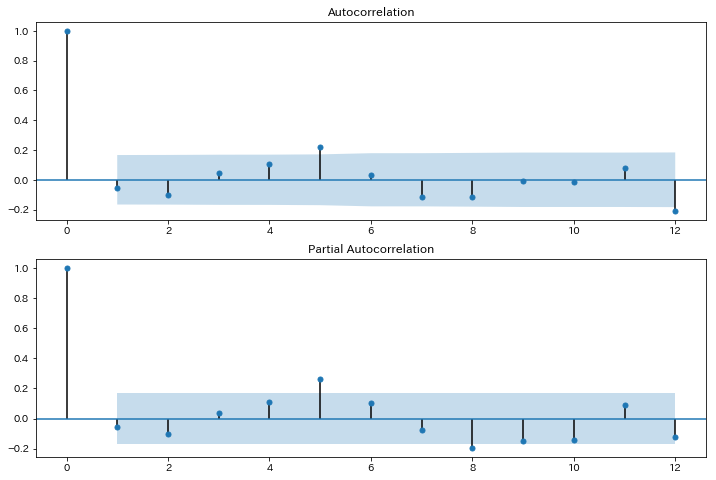

In [8]:
# 統計モデルのサマリー
print(sarima.summary())

# 残差のチェック
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))

# 自己相関
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=12, ax=ax1)

# 偏自己相関
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=12, ax=ax2)